# INTRO

Using Recurrent Neural Network which is better for timeseries prediction, we would like to predict the price of Frozen Dessert for a company.

# LIBRARIES AND DATASET

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("Frozen_Dessert_Production.csv", index_col="DATE", parse_dates = True)
data

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


<AxesSubplot:xlabel='DATE'>

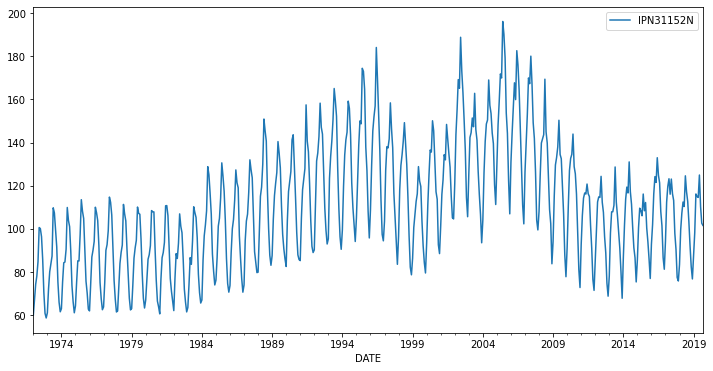

In [3]:
data.plot(figsize=(12,6))

# SPLITING THE DATASET

In [4]:
len(data)

573

In [5]:
test_size = 12
test_ind = len(data) - test_size

In [6]:
train = data.iloc[:test_ind]
test = data.iloc[test_ind:]

In [7]:
print(len(train))
print(len(test))

561
12


# TRANSDORMING THE DATASET INTO LOWER NUMBERS WITH STANDARD DEVIATION

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)

MinMaxScaler()

In [11]:
scaled_train = scaler.transform(train)

In [12]:
scaled_test = scaler.transform(test)

# CREATING THE MODEL

Next, we will need the Time Series Generator, which is a class that allows you to generate batches of temporal data for input into a deep learning model. It takes in a sequence of data points (e.g., time-series data) and returns a set of input/output pairs that can be fed into a neural network. The TimeseriesGenerator can be used for both supervised and unsupervised learning tasks.

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
length = 11
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)

For this model we will need one layer of LSTM with 200 cicles with the shape of our data set. 

The next one is the Dense layer which is a basic building block of a neural network, where each neuron in the layer is connected to every neuron in the previous layer. The Dense layer is also known as a fully connected layer, because every neuron in the layer is connected to every neuron in the previous layer.

And finally, the compile layer that will be ready to be trained using the specified optimizer and loss function. During training, the model will update its parameters (i.e., weights and biases) to minimize the loss function, with the ultimate goal of making more accurate predictions on new, unseen data.

The optimizer is Adam  that is commonly used in deep learning. It is an adaptive learning rate method that combines the benefits of both Adagrad and RMSProp algorithms. By using adaptive learning rates for each parameter, Adam is able to converge faster and has been shown to perform well on a wide range of deep learning problems.

And the loss fuctions is MSE that is commonly used in regression problems. It measures the average squared difference between the predicted and actual values. The goal of training a neural network with MSE loss is to minimize the difference between the predicted and actual values.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
model = Sequential()
model.add(LSTM(200, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mse")

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


# VALIDATING OUR MODEL

By using a TimeseriesGenerator for validation data, we can evaluate the performance of our model on data that it has not seen during training. This can help us avoid overfitting, where the model performs well on the training data but poorly on new, unseen data. We can use the validation data to monitor the model's performance during training and make adjustments to the model or training process as needed.

In [18]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)

We add the Early Stopping, this will break our training when the "val_loss" is getting worse.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor = "val_loss", patience = 2)

# TRAINING THE MODEL

In [21]:
model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks=[early_stop])

Epoch 1/20


C:\Users\ulise\AppData\Local\Temp/ipykernel_13120/998452603.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks=[early_stop])


550/550 [==============================] - 6s 8ms/step - loss: 0.0217 - val_loss: 0.0039
Epoch 2/20
550/550 [==============================] - 4s 7ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 3/20
550/550 [==============================] - 5s 8ms/step - loss: 0.0042 - val_loss: 0.0039


# VISUALIZATION OF OUR MODEL PERFORMANCE

<AxesSubplot:>

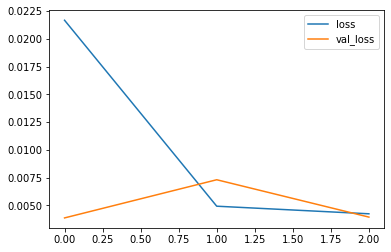

In [22]:
loss = pd.DataFrame(model.history.history)
loss.plot()

# MAKING PREDICTIONS

We need a for cicle to get the predictions and save them in a same list.

In [23]:
test_pre = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_pre = model.predict(current_batch)[0]
    test_pre.append(current_pre)
    current_batch = np.append(current_batch[:,1:,:], [[current_pre]], axis = 1)

1/1 [==============================] - 0s 21ms/step


With standardize the results.

In [24]:
true_pre = scaler.inverse_transform(test_pre)

In [25]:
test["Predictions"] = true_pre
test

C:\Users\ulise\AppData\Local\Temp/ipykernel_13120/3919119328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = true_pre


,IPN31152N,Predictions
DATE,,
2018-10-01,92.1321,93.430267
2018-11-01,82.4347,88.564410
2018-12-01,76.7608,88.013951
2019-01-01,86.9988,91.064082
2019-02-01,98.1116,96.031174
2019-03-01,116.1718,101.695875
2019-04-01,114.9703,106.719125
2019-05-01,114.5613,110.225845
2019-06-01,124.9605,110.535925


In [26]:
test.columns = ["Production","Predictions"]

This is the predictions of our model. Which we can see it is pretty close to the true value.

<AxesSubplot:xlabel='DATE'>

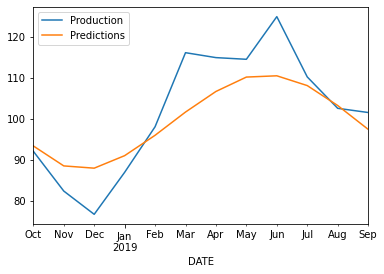

In [27]:
test.plot()

# RESULTS

As result of the metrics of MSE, we got a 7.7. Which means that the production predictions is close to the true value in a range of 7.7 points.

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
np.sqrt(mean_squared_error(test["Production"], test["Predictions"]))

7.708087475624952

# FORECASTING

We get the future production but with a difference that will be from the next 12 months.

In [50]:
forecast = []
periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 20ms/step


In [51]:
forecast = scaler.inverse_transform(forecast)

We assign the value with their correspondence time date.

In [52]:
forecast_index = pd.date_range(start="2019-10-01", periods = periods, freq = "MS")

In [53]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ["Forecast"])

# VISUALIZATION OF OUR POSSIBLE PRODUCTION BY THAT TIME

(540.0, 612.0)

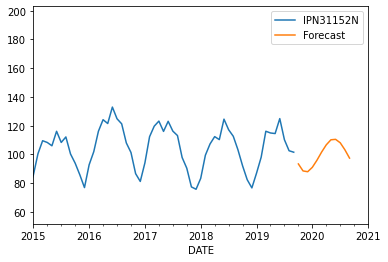

In [58]:
ax = data.plot()
forecast_df.plot(ax=ax)
plt.xlim("2015-01-01", "2021-1-01")